In [1]:
import sys

sys.path.append("..")

import critical_loads as cl
import geopandas as gpd
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import rasterio
import rioxarray as rio
import xarray as xr
from geocube.api.core import make_geocube
from rasterio.enums import Resampling

In [2]:
# Connect to PostGIS
eng = nivapy.da.connect_postgis(database="critical_loads", admin=True)

Username:  ········
Password:  ········


Connection successful.


# Vegetation workflow: updating empirical critical loads

We have a 30 m resolution map of land cover for Norway with 25 classes (NORUT codes):

    shared/critical_loads/raster/sat_veg_30m_norut.tif
    
For each class, the database table `vegetation.land_class_crit_lds` specifies an empirically derived critical load.

Kari would like to update the critical loads for each class. In principle, this just involves updating the values in the database and everything will run as before. However, we would also like to include a change to the way critical loads for water are handled.

NORUT class 22 (water) should be divided into three subclasses, based on biogeographical zone and TOC concentration:

 * Water with a TOC concentration >= 15 mg/l should have a CL of 5 kg/ha/yr (regardless of biogeographical zone)
 * Water in Boreal or Atlantic zones (labelled `boreal` from now on) with a TOC concentration < 15 mg/l should have a CL of 3 kg/ha/yr
 * Water in Alpine or Arctic zones (labelled `alpine` from now on) with a TOC concentration < 15 mg/l should have a CL of 2 kg/ha/yr
 
The old empirical critical loads are archived in the Excel file here:

    ../../vegetation/sat_veg_land_use_classes_2018.xlsx
    
and the updated version is here:

    ../../vegetation/sat_veg_land_use_classes_2022.xlsx
    
Note that in the new file, class 22 (water) has been subdivided into three: 221, 222 and 223, corresponding to `alpine`, `boreal` and `>= 15 mg/l`, respectively. The aims of this notebook are to:

 1. Create new land cover datasets at 30, 60 and 120 m resolution. These are based on the original rasters, but with class 22 divided as described above
 
 2. Replace the existing values in the database with updated values from `sat_veg_land_use_classes_2022.xlsx`
 
 3. Calculate exceedances for vegetation for each time period using BLR-based deposition

In [3]:
# Paths to data
zone_shp = r"/home/jovyan/shared/critical_loads/biogeo_regions/BiogeoRegions2016.shp"
norut_path = r"/home/jovyan/shared/critical_loads/raster/sat_veg_30m_norut.tif"
toc_path = r"/home/jovyan/shared/critical_loads/norway_interpolated_toc_2019.nc"

## 1. Biogeographical zones

Downloaded from [here](https://www.eea.europa.eu/data-and-maps/data/biogeographical-regions-europe-3).

,zone,geometry,PK_UID,short_name,pre_2012,code,name,zone_id
0,alpine,"MULTIPOLYGON (((973551.357 7909304.322, 973119...",1,alpine,ALP,Alpine,Alpine Bio-geographical Region,1
1,boreal,"MULTIPOLYGON (((594464.147 6355514.648, 594501...",6,boreal,BOR,Boreal,Boreal Bio-geographical Region,2


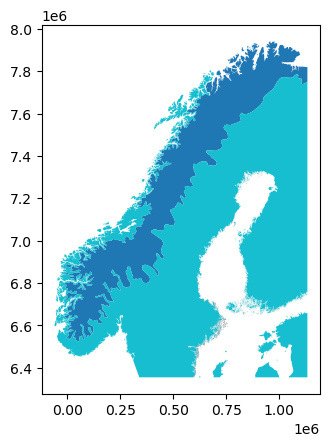

In [4]:
# Define IDs for biogeo zones of interest
remap_dict = {"alpine": 1, "boreal": 2}

# Get bound of 30 m veg raster
with rasterio.open(norut_path) as src:
    bounds = src.bounds

# Clip, group and dissolve
gdf = gpd.read_file(zone_shp).to_crs("epsg:25833")
gdf = gpd.clip(gdf, mask=bounds, keep_geom_type=True)
gdf["zone"] = gdf["short_name"].replace(
    {"boreal": "boreal", "atlantic": "boreal", "alpine": "alpine", "arctic": "alpine"}
)
gdf = gdf.query("zone in ('boreal', 'alpine')")
gdf = gdf.dissolve("zone").reset_index()
gdf["zone_id"] = gdf["zone"].replace(remap_dict)

gdf.plot(column="zone")
gdf

## 2. TOC dataset

Based on the 2019 1000 Lakes data, spatially interpolated to 1 km resolution using a GAM.

<xarray.Dataset>
Dimensions:      (y: 1496, x: 1198)
Coordinates:
  * y            (y) float64 6.446e+06 6.448e+06 ... 7.94e+06 7.942e+06
  * x            (x) float64 -7.95e+04 -7.85e+04 ... 1.116e+06 1.118e+06
    year         int64 2019
    spatial_ref  int64 ...
Data variables:
    TOC_mgpl     (y, x) float32 ...

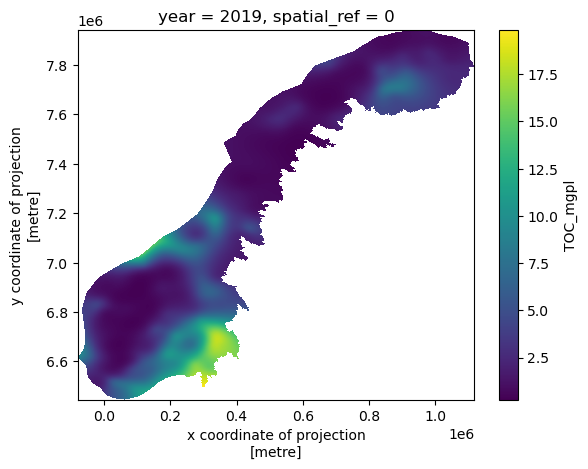

In [5]:
toc_ds = xr.open_dataset(toc_path).sel(year=2019)
toc_ds["TOC_mgpl"].plot()
toc_ds

## 3. Combine biogeographical zones and TOC

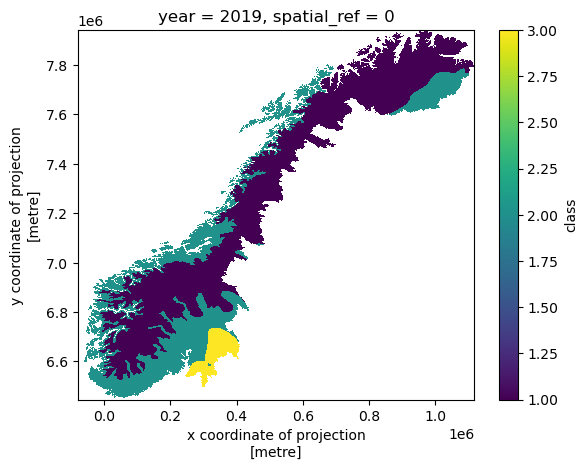

In [6]:
# Convert vector zones to raster matching TOC gird
zone_ds = make_geocube(vector_data=gdf, like=toc_ds, measurements=["zone_id"])

# Build array with ID for each class of interest:
#     toc < 15 and alpine => 1
#     toc < 15 and boreal => 2
#     toc >= 15           => 3
toc = toc_ds["TOC_mgpl"].data
zone = zone_ds["zone_id"].data
classes = np.full_like(toc, np.nan)
classes[(toc < 15) & (zone == 1)] = 1
classes[(toc < 15) & (zone == 2)] = 2
classes[toc >= 15] = 3
toc_ds["class"] = (("y", "x"), classes)
toc_ds["class"].plot()

## 4. Link to vegetation data

In [7]:
# Resample and reproject classes to match veg data
veg_da = rio.open_rasterio(norut_path).sel(band=1)
cls_da = toc_ds["class"].rio.reproject_match(veg_da)

# Make sure co-ords match exactly (avoids floating point error)
cls_da = cls_da.assign_coords(
    {
        "x": veg_da.x,
        "y": veg_da.y,
    }
)

# Change NORUT class 22 to class 220, then add the biogeoTOC codes from above
#     toc < 15 and alpine => 221
#     toc < 15 and boreal => 222
#     toc >= 15           => 223
veg_data = veg_da.data
cls_data = cls_da.data
veg_data[veg_data == 22] = 220
veg_data[veg_data == 220] = veg_data[veg_data == 220] + cls_data[veg_data == 220]
veg_da.data = veg_data

In [8]:
# Save
out_path = (
    r"/home/jovyan/shared/critical_loads/raster/sat_veg_30m_norut_subdiv_water.tif"
)
veg_da.rio.to_raster(out_path, compress="lzw", dtype="uint8")

In [9]:
# Save downsampled versions
for res in [60, 120]:
    veg_da_resamp = veg_da.rio.reproject(
        dst_crs="epsg:32633",
        resolution=res,
        resampling=Resampling.nearest,
    )
    out_path = f"/home/jovyan/shared/critical_loads/raster/sat_veg_{res}m_norut_subdiv_water.tif"
    veg_da_resamp.rio.to_raster(out_path, compress="lzw", dtype="uint8")

## 5. Update empirical critical loads in database

In [10]:
xl_path = r"../../vegetation/sat_veg_land_use_classes_2022.xlsx"
df = pd.read_excel(xl_path, sheet_name="eunis_lower_case")
df

,norut_code,norut_veg_class,eunis_code,eunis_veg_class,comment,cl_meq_m2_yr,cl_100smgn_m2_yr,cl_mgn_m2_yr
0,1,Barskog - tett tresjikt,T3F,Dark taiga,NaN,21.428571,3,300
1,2,Barskog og blandingsskog - åpent tresjikt,T3,Coniferous forest,NaN,21.428571,3,300
2,3,Lavrik furuskog,T3G,Pinus sylvestris light taiga,NaN,14.285714,2,200
3,4,Lågurtskog og edellauvskog,T1,Deciduous broadleaved forest,NaN,71.428571,10,1000
4,5,Høgstaude- og storbregnelauvskog,T1,Deciduous broadleaved forest,NaN,71.428571,10,1000
5,6,Blåbær- og småbregnebjørkeskog,T1C15,Eurasian boreal Betula woods,NaN,21.428571,3,300
6,7,Kreklingbjørkeskog,T1C15,Eurasian boreal Betula woods,NaN,21.428571,3,300
7,8,Lavrik bjørkeskog,T1C15,Eurasian boreal Betula woods,NaN,21.428571,3,300
8,9,Tuemyr og lågvokst fastmattemyr,Q1,Raised and blanket bogs,NaN,35.714286,5,500
9,10,Høgvokst mattemyr (Høgstarrmyr),Q2,"Valley mires, poor fens and transition mires",NaN,35.714286,5,500


In [11]:
# Delete existing data from db
sql = "TRUNCATE vegetation.land_class_crit_lds, vegetation.exceedance_stats_land_class"
eng.execute(sql)

# Add new records
df.to_sql(
    "land_class_crit_lds",
    con=eng,
    schema="vegetation",
    if_exists="append",
    index=False,
)

28

## 6. Reclassify vegetation dataset

In [12]:
# Read reclassification table from db
sql = "SELECT * FROM vegetation.land_class_crit_lds"
rc_df = pd.read_sql(sql, eng)

# Set land class code as index
rc_df.index = rc_df["norut_code"]
del rc_df["norut_code"]

rc_df

,norut_veg_class,eunis_code,eunis_veg_class,comment,cl_meq_m2_yr,cl_100smgn_m2_yr,cl_mgn_m2_yr
norut_code,,,,,,,
1,Barskog - tett tresjikt,T3F,Dark taiga,None,21.428571,3,300
2,Barskog og blandingsskog - åpent tresjikt,T3,Coniferous forest,None,21.428571,3,300
3,Lavrik furuskog,T3G,Pinus sylvestris light taiga,None,14.285714,2,200
4,Lågurtskog og edellauvskog,T1,Deciduous broadleaved forest,None,71.428571,10,1000
5,Høgstaude- og storbregnelauvskog,T1,Deciduous broadleaved forest,None,71.428571,10,1000
6,Blåbær- og småbregnebjørkeskog,T1C15,Eurasian boreal Betula woods,None,21.428571,3,300
7,Kreklingbjørkeskog,T1C15,Eurasian boreal Betula woods,None,21.428571,3,300
8,Lavrik bjørkeskog,T1C15,Eurasian boreal Betula woods,None,21.428571,3,300
9,Tuemyr og lågvokst fastmattemyr,Q1,Raised and blanket bogs,None,35.714286,5,500


In [13]:
cell_size = 120
mask_tif = f"/home/jovyan/shared/critical_loads/raster/blr_land_mask_{cell_size}m.tif"
veg_tif = f"/home/jovyan/shared/critical_loads/raster/sat_veg_{cell_size}m_norut_subdiv_water.tif"
rc_tif = f"/home/jovyan/shared/critical_loads/raster/sat_veg_{cell_size}m_cl_100smgn_m2_yr_subdiv_water.tif"
cl.reclassify_raster(veg_tif, mask_tif, rc_tif, rc_df, "cl_100smgn_m2_yr", 255)

## 7. Exceedances for vegetation

In [14]:
# User options
cell_size = 120

# Series to use
series_dict = {
    1: ("7882", 1978, 1982),
    29: ("8387", 1983, 1987),
    30: ("8892", 1988, 1992),
    2: ("9296", 1992, 1996),
    3: ("9701", 1997, 2001),
    4: ("0206", 2002, 2006),
    25: ("0711", 2007, 2011),
    26: ("1216_old", 2012, 2016),
    66: ("1721_old", 2017, 2021),
    67: ("1721_blrgrid", 2017, 2021),
}

Processing 1978 to 1982
Processing 1983 to 1987
Processing 1988 to 1992
Processing 1992 to 1996
Processing 1997 to 2001
Processing 2002 to 2006
Processing 2007 to 2011
Processing 2012 to 2016
Processing 2017 to 2021
Processing 2017 to 2021


,series_id,medium,total_area_km2,exceeded_area_km2,exceeded_area_pct,short_name
0,1,vegetation,320585,134864,42,7882
0,29,vegetation,320585,144876,45,8387
0,30,vegetation,320585,116078,36,8892
0,2,vegetation,320585,109212,34,9296
0,3,vegetation,320585,112436,35,9701
0,4,vegetation,320391,117009,37,0206
0,25,vegetation,320585,115739,36,0711
0,26,vegetation,320585,119201,37,1216_old
0,66,vegetation,322183,116794,36,1721_old
0,67,vegetation,322183,47809,15,1721_blrgrid


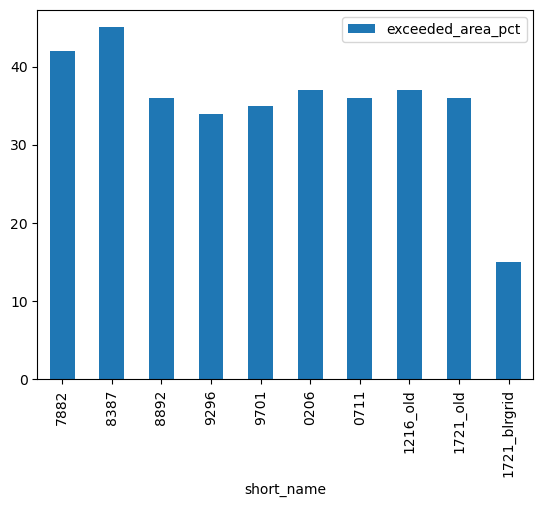

In [15]:
# CL raster (created above)
cl_tif = f'/home/jovyan/shared/critical_loads/raster/sat_veg_{cell_size}m_cl_100smgn_m2_yr_subdiv_water.tif'

df_list = []
for ser_id, period in series_dict.items():
    short_name = period[0]
    st_per = period[1]
    end_per = period[2]
    print(f"Processing {st_per} to {end_per}")

    ndep_tif = f'/home/jovyan/shared/critical_loads/raster/deposition/ndep_mgpm2pyr_{short_name}_{cell_size}m.tif'
    ex_tif = f'/home/jovyan/shared/critical_loads/raster/exceedance/{short_name}/veg_ex_mgpm2pyr_{short_name}_{cell_size}m.tif'
    ex_tif_bool = f'/home/jovyan/shared/critical_loads/raster/exceedance/{short_name}/veg_ex_{short_name}_{cell_size}m_bool.tif'
    ex_df = cl.calc_vegetation_exceedance(ndep_tif, cl_tif, ex_tif, ex_tif_bool, ser_id)
    ex_df["short_name"] = short_name
    df_list.append(ex_df)
ex_df = pd.concat(df_list, axis="rows")
ex_df.plot.bar(x="short_name", y="exceeded_area_pct")
ex_df